# Team Orientering Problem

## Stochastic version

Implementation of the Sample Average Approsimation (SAA) algorithm.
The evaluation of the expected value of a given solution is done in several ways:

* solving a stochastic programming model with a large number of scenarios with the first stage variables (that define the routes) fixed,
* running the simheuristic simulator,
* running the simulator implemented in the function `simulate_sol`.

The solution of the large 2nd-stage problem is solved **only for the best solution found**, while the simulators are run **for each solution**.

Instances: a selection of Chao.

In [1]:
import math
from pyomo.environ import *
from pyomo.opt import *

import scipy
import numpy as np
import random
import matplotlib.pyplot as plt
import cloudpickle
import os
import time # count clock time
import seaborn as sns
import pandas as pd
import shutil
import top_pjs_heuristic
#import routeCache
#import routing_objects
#import simulation
#import vns
#import input_output_objects

In [2]:
#top_pjs_heuristic.my_func()


In [3]:
# Solver options --------------------------------------------------------
opt = SolverFactory("cplex") # glpk gurobi cplex
#opt= top_pjs_heuristic.opt.CreateSolver("Simheuristics")
solver_time = 20  # Seconds that the solver has to solve a replica
opt.options['TimeLimit'] = solver_time  # set maximum solver time

# Instance definition ---------------------------------------------------
instanceName = 'p2.4.h'      # Name of the file with the data
dataName = '../data/pythonChao/' + instanceName + '.dat'

# SAA parameters
np.random.seed(12345)
S = 25           # Number of scenarios for the complete model
cVar = 0.75     # Variability level
extra_time = 1  # Maximum extra time allowed for a particular route in any scenario (extra_time*model.t_max)
S_large = 100   # Number of scenarios for evaluating the second stage
R = 10          # Replicas of the stochastic model

## Model definition
### Sets and parameters

Dimensions:

* $n$: Number of locations
* $m$: Number of vehicles
* $s$: Number of scenarios


Sets:

* $N = \{0,1, ..., n, n+1\}$: Set of nodes composed of the customer locations $L = \{1, ..., n\}$, $\{0\}$ as the origin depot and $\{n+1\}$ as the arrival depot
* $M = \{1, ..., m\}$: Set of vehicles 
* $A = \{(i,j) \vert i \in N, j \in N, i \neq j\}$: Set of arcs connecting the locations
* $S = \{1, ..., s\}$: Set of travelling time scenarios

Parameters:

* $U_i$: Utility (reward) gained by visiting location $i$.
* $T_{ij}^s$: Travelling times between two locations in scenario $s$
* $t\_max$: Maximum time available per route

Build the set of scenarios for the random travelling time. The stochastic travel times are assumed to be distributed as a logNormal with the same expected value as the deterministic value, and a variance proportional to this travelling time. The parameter $c$ indicates the level of uncertainty considered.

In [4]:
def stoch_times(model,i,j,s):
    time = model.time[i,j]
    if (time == 0): # Departure/Arrival depot
        return (time)
    if (cVar == 0): # Deterministic problem
        return (time)
    if (s == 1): # First scenario consider the deterministic scenario
        return (time)
    avg_t = time
    var_t = time*cVar
    mu = np.log(avg_t) - 0.5*np.log(1+var_t/(avg_t**2))
    sigma = np.sqrt(np.log(1+var_t/(avg_t**2)))
    
    return(round(np.random.lognormal(mu,sigma),1))

### Variables

First stage variables:
* $x_{ij}^k$: Whether vehicle $k$ goes from node $i$ to node $j$
* $y_{i}^k$: Position of node $i$ in tour make by vehicle $k$

Second stage Stochastic variables:
* $z^{ks}$: Binary variable indicating whether route $k$ on scenario $s$ can be completed within the time frame
* $r^{ks}$: Total reward for route $k$ on scenario $s$

### Objective

For the deterministic version, the objective is to maximize the sum of the revenue collected by all vehicles which visit as many customers as possible within a time range. The vehicle/route is rewarded for each customer visited.

$$
\max \sum_{k=1}^m \sum_{(i,j) \in A} U_j x_{ij}^k 
$$

For the stochastic versions, given that the travelling times are uncertain, for each scenario a route will recieve the rewards collected on its route only when all the nodes can be visited within the given time frame. To compute this measure, the reward is computed within the constraint set, forcing to be zero for a particular route and scenario if the route cannot be fully accomplished within the time allowed.

$$
\max \frac{1}{S} \sum_{s=1}^S (\sum_{k=1}^m r^{ks})
$$

In [5]:
# Stochastic objective function
def Total_Utility_Stoch_rule(model):
    return (sum(model.r[k,s] for k in model.M for s in model.S)/(len(model.S)))

### Constraints

Each location can be visited at most once:

$$
\sum_{k=1}^m \sum_{(i,j) \in A} x_{ij}^k \le 1 \qquad j \in N
$$

In [6]:
def Visit_Once_rule(model, j):
    return (sum(model.x[i,j,k] for (i,jj,k) in model.A*model.M if jj==j)  <= 1)

Flow balance constraints: "Any arrival to a node has to be compensated with a departure"

$$
\sum_{i \in N} x_{ip}^k   =  \sum_{j \in N} x_{pj}^k   \qquad p \in L, k \in M
$$

In [7]:
def Balance_flow_rule(model,p,k):
    return sum(model.x[i,j,k] for (i,j) in model.A if i==p) - sum(model.x[i,j,k] for (i,j) in model.A if j==p) == 0

Prevent the construction of subtours:

$$
y_i - y_j + 1 \le (1-x_{ij}^k) n \qquad i \in N, j \in N, k \in M
$$
 which is equivalent to
$$
y_i - y_j + n x_{ij}^k \le n - 1 \qquad i \in N, j \in N, k \in M
$$

We also ensure that variables with equal origin and destination are fixed to 0.

In [8]:
def No_Subtours_rule(model,i,j,k):
    if (i != j):
        #return (model.y[i,k] - model.y[j,k] + (max_visited)*model.x[i,j,k] <= (max_visited - 1))
        return (model.y[i] - model.y[j] + (model.n)*model.x[i,j,k] <= (model.n - 1))
    return model.x[i,j,k] == 0 # Remove diagonal elements

To tight the formulation, it might help to add a constraint which forces $y_i^k$ to be 0 if the route does not visit this node:

$$
y_{j}^k \le n \sum_{j \in N} x_{ij}^k \qquad j \in L, k \in M
$$

Start variables $y$ with the first customer visited:
$$
y_j^k \ge x_{0j}^k \qquad j \in N, k \in M
$$

Capacity constraint: ensure that the expected time in traversing any route does not exceed a given threshold for a particular scenario $s$, and if so, the variable $z^{ks}$ is activated. $B$ is a 'large' value.

$$
\sum_{(i,j) \in A} T_{ij}^s x_{ij}^k \le t\_max  + B z^{ks} \qquad k \in M, s \in S
$$

In [9]:
def Max_Time_Stoch_rule(model, k, s):
    return (sum(model.time_stoch[i,j,s]*model.x[i,j,k] for (i,j) in model.A) - extra_time*model.t_max*model.z[k,s] <= model.t_max)

Compute the rewards. Because $r^{ks}$ is maximized in the objective function, the optimization will favor the highest value, but if the route takes longer than allowed it will be forced to have a 0 reward.

$$
r^{ks} \le \sum_{(i,j) \in A} U_j x_{ij}^k \qquad k \in M, s \in S
$$

$$
r^{ks} \le big_M (1-z^{ks}) \qquad k \in M, s \in S
$$

In [10]:
def Reward_scn_rule(model,k,s):
    return(model.r[k,s] <= sum(model.utility[j]*model.x[i,j,k] for (i,j) in model.A))

def Reward_full_Route_rule(model, k, s):
    bigM = 1000
    return(model.r[k,s] <= bigM*(1-model.z[k,s]))

Ensure that each vehicle departs from the depot:

$$
\sum_{j=1}^n x_{0j}^k = 1 \qquad k \in M
$$

In [11]:
def Departures_rule(model, k):
    return sum(model.x[i,j,k] for (i,j) in model.A if i == 0) == 1

Ensure that all vehicles reach the arrival depot:

$$
\sum_{i=1}^n\sum_{k=1}^m x_{i,n+1}^k = 1 \qquad k \in M
$$

In [12]:
def Arrivals_rule(model, k):
    return sum(model.x[i,j,k] for (i,j) in model.A if j == (model.n-1)) == 1

No arrivals at the depot

In [13]:
def No_arrivals_depot_rule(model):
    return(sum(model.x[i,j,k] for (i,j,k) in model.A*model.M if j == 0) == 0)

In [14]:
def build_mod(sizeScnTree = 10):
    mod = AbstractModel("Stochastic mod")
    
    mod.m = Param(within=PositiveIntegers) # Number of vehicles
    mod.M = RangeSet( mod.m ) #Set of Vehicles

    mod.n = Param(within=PositiveIntegers) # Number of locations to visit
    mod.L = RangeSet( mod.n - 2 )  # Set of locations
    mod.depar = Set(initialize = [0]) # Departure depot
    mod.arriv = RangeSet( mod.n - 1, mod.n - 1) # Arrival depot
    mod.N = mod.depar | mod.L | mod.arriv  # Set of nodes

    mod.A = Set(initialize = mod.N*mod.N) # Set of arcs

    mod.time    = Param(mod.N, mod.N, within=NonNegativeReals, default = 0) # Travelling time between two pairs of locations

    mod.t_max   = Param(within=PositiveReals) # Maximum travelling time
    mod.utility = Param(mod.N, default = 0) # Utility/reward gained by visiting each location

    mod.nScn = sizeScnTree # Number of scenarios
    mod.S = RangeSet(sizeScnTree)   # Set of scenarios

    mod.time_stoch = Param(mod.N, mod.N, mod.S, initialize = stoch_times, mutable = True)

    # Variables
    mod.x = Var(mod.A, mod.M, within=Binary)
    mod.y = Var(mod.N, within=NonNegativeReals)

    mod.z = Var(mod.M, mod.S, within = Binary)
    mod.r = Var(mod.M, mod.S, within = NonNegativeReals)

    # Objective Function
    mod.Total_Utility_Stoch = Objective(rule=Total_Utility_Stoch_rule, sense = maximize)

    # Constraints
    mod.Visit_Once        = Constraint(mod.L,               rule = Visit_Once_rule)
    mod.Balance_flow      = Constraint(mod.L, mod.M,        rule = Balance_flow_rule)
    mod.No_Subtours       = Constraint(mod.N, mod.N, mod.M, rule = No_Subtours_rule)
    mod.Max_Time_Stoch    = Constraint(mod.M, mod.S,        rule = Max_Time_Stoch_rule)
    mod.Reward_scn        = Constraint(mod.M, mod.S,        rule = Reward_scn_rule)
    mod.Reward_full_Route = Constraint(mod.M, mod.S,        rule = Reward_full_Route_rule)
    mod.Max_Departures    = Constraint(mod.M,               rule = Departures_rule)
    mod.Arrivals          = Constraint(mod.M,               rule = Arrivals_rule)
    mod.No_arrivals_depot = Constraint(                     rule = No_arrivals_depot_rule)
        
    return(mod)


os.chdir('./..')
os.getcwd()

In [15]:
modelSP = build_mod(S)
instanceSP = modelSP.create_instance(dataName)

    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    

In [16]:
instanceSP.pprint()

14 Set Declarations
    A : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :  441 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15

        Key          : Value
           (0, 0, 1) :   0.0
           (0, 0, 2) :   0.0
           (0, 0, 3) :   0.0
           (0, 0, 4) :   0.0
           (0, 0, 5) :   0.0
           (0, 0, 6) :   0.0
           (0, 0, 7) :   0.0
           (0, 0, 8) :   0.0
           (0, 0, 9) :   0.0
          (0, 0, 10) :   0.0
          (0, 0, 11) :   0.0
          (0, 0, 12) :   0.0
          (0, 0, 13) :   0.0
          (0, 0, 14) :   0.0
          (0, 0, 15) :   0.0
          (0, 0, 16) :   0.0
          (0, 0, 17) :   0.0
          (0, 0, 18) :   0.0
          (0, 0, 19) :   0.0
          (0, 0, 20) :   0.0
          (0, 0, 21) :   0.0
          (0, 0, 22) :   0.0
          (0, 0, 23) :   0.0
          (0, 0, 24) :   0.0
          (0, 0, 25) :   0.0
           (0, 1, 1) :  4.44
           (0, 1, 2) :   3.8
           (0, 1, 3) :   5.0
           (0, 1, 4) :   3.3
           (0, 1, 5) :   3.3
           (0, 1, 6) :   8.9
           (0, 1, 7) :   7.1
           (0, 1, 8) :   4.3
           (0,

          (1, 8, 17) :   3.5
          (1, 8, 18) :   5.6
          (1, 8, 19) :   2.5
          (1, 8, 20) :   3.9
          (1, 8, 21) :   3.8
          (1, 8, 22) :   4.1
          (1, 8, 23) :   1.8
          (1, 8, 24) :   7.8
          (1, 8, 25) :   2.5
           (1, 9, 1) :  3.77
           (1, 9, 2) :   3.2
           (1, 9, 3) :   1.8
           (1, 9, 4) :   3.5
           (1, 9, 5) :   4.1
           (1, 9, 6) :   8.2
           (1, 9, 7) :   2.9
           (1, 9, 8) :   1.7
           (1, 9, 9) :   3.7
          (1, 9, 10) :   3.2
          (1, 9, 11) :   3.7
          (1, 9, 12) :   2.9
          (1, 9, 13) :   2.9
          (1, 9, 14) :   2.4
          (1, 9, 15) :   3.1
          (1, 9, 16) :   5.8
          (1, 9, 17) :   2.9
          (1, 9, 18) :   5.0
          (1, 9, 19) :   3.0
          (1, 9, 20) :   3.7
          (1, 9, 21) :   2.3
          (1, 9, 22) :   4.7
          (1, 9, 23) :   3.1
          (1, 9, 24) :   4.0
          (1, 9, 25) :   2.4
          (1, 

          (3, 6, 16) :   5.5
          (3, 6, 17) :   9.3
          (3, 6, 18) :   9.6
          (3, 6, 19) :   3.9
          (3, 6, 20) :   6.7
          (3, 6, 21) :   9.3
          (3, 6, 22) :   4.8
          (3, 6, 23) :   7.5
          (3, 6, 24) :   6.3
          (3, 6, 25) :   7.4
           (3, 7, 1) :  5.99
           (3, 7, 2) :   8.7
           (3, 7, 3) :   8.8
           (3, 7, 4) :   5.1
           (3, 7, 5) :   5.5
           (3, 7, 6) :   4.8
           (3, 7, 7) :   3.9
           (3, 7, 8) :   6.5
           (3, 7, 9) :   6.3
          (3, 7, 10) :   3.8
          (3, 7, 11) :   8.6
          (3, 7, 12) :   2.9
          (3, 7, 13) :   3.2
          (3, 7, 14) :   5.6
          (3, 7, 15) :   8.2
          (3, 7, 16) :   8.0
          (3, 7, 17) :  12.3
          (3, 7, 18) :   5.9
          (3, 7, 19) :   6.7
          (3, 7, 20) :   5.3
          (3, 7, 21) :   1.6
          (3, 7, 22) :   3.4
          (3, 7, 23) :   5.0
          (3, 7, 24) :   4.4
          (3, 

          (4, 12, 8) :   6.2
          (4, 12, 9) :   3.2
         (4, 12, 10) :   6.2
         (4, 12, 11) :   2.3
         (4, 12, 12) :   5.8
         (4, 12, 13) :   2.9
         (4, 12, 14) :   4.6
         (4, 12, 15) :   3.2
         (4, 12, 16) :   4.4
         (4, 12, 17) :   1.9
         (4, 12, 18) :   3.7
         (4, 12, 19) :   6.0
         (4, 12, 20) :   6.4
         (4, 12, 21) :   3.1
         (4, 12, 22) :   3.9
         (4, 12, 23) :   2.4
         (4, 12, 24) :   5.4
         (4, 12, 25) :   7.2
          (4, 13, 1) :   5.7
          (4, 13, 2) :   8.3
          (4, 13, 3) :   6.1
          (4, 13, 4) :   7.2
          (4, 13, 5) :   6.4
          (4, 13, 6) :   4.6
          (4, 13, 7) :   6.1
          (4, 13, 8) :   5.2
          (4, 13, 9) :   4.8
         (4, 13, 10) :   6.2
         (4, 13, 11) :   3.8
         (4, 13, 12) :   4.5
         (4, 13, 13) :   4.3
         (4, 13, 14) :   6.0
         (4, 13, 15) :   5.0
         (4, 13, 16) :  11.1
         (4, 1

         (5, 17, 24) :  12.4
         (5, 17, 25) :   7.3
          (5, 18, 1) : 10.82
          (5, 18, 2) :   8.3
          (5, 18, 3) :  10.9
          (5, 18, 4) :  14.5
          (5, 18, 5) :  11.4
          (5, 18, 6) :  12.5
          (5, 18, 7) :   7.8
          (5, 18, 8) :   8.2
          (5, 18, 9) :   8.8
         (5, 18, 10) :  14.3
         (5, 18, 11) :   9.8
         (5, 18, 12) :  14.7
         (5, 18, 13) :  11.0
         (5, 18, 14) :  10.3
         (5, 18, 15) :   9.2
         (5, 18, 16) :  11.7
         (5, 18, 17) :   7.3
         (5, 18, 18) :  15.2
         (5, 18, 19) :  11.5
         (5, 18, 20) :  10.8
         (5, 18, 21) :   6.1
         (5, 18, 22) :  17.4
         (5, 18, 23) :  12.9
         (5, 18, 24) :  12.7
         (5, 18, 25) :   9.1
          (5, 19, 1) :   7.1
          (5, 19, 2) :   7.9
          (5, 19, 3) :   4.2
          (5, 19, 4) :   7.6
          (5, 19, 5) :   6.1
          (5, 19, 6) :   9.1
          (5, 19, 7) :   8.3
          (5, 

          (7, 2, 15) :   2.7
          (7, 2, 16) :   2.3
          (7, 2, 17) :   4.0
          (7, 2, 18) :   2.7
          (7, 2, 19) :   3.2
          (7, 2, 20) :   6.4
          (7, 2, 21) :   3.6
          (7, 2, 22) :   6.4
          (7, 2, 23) :   5.3
          (7, 2, 24) :   5.4
          (7, 2, 25) :   1.7
           (7, 3, 1) :  5.99
           (7, 3, 2) :   8.8
           (7, 3, 3) :   9.2
           (7, 3, 4) :   4.0
           (7, 3, 5) :   7.5
           (7, 3, 6) :   7.1
           (7, 3, 7) :   9.3
           (7, 3, 8) :   2.4
           (7, 3, 9) :   7.0
          (7, 3, 10) :   7.3
          (7, 3, 11) :   6.8
          (7, 3, 12) :   4.6
          (7, 3, 13) :   3.5
          (7, 3, 14) :   5.6
          (7, 3, 15) :   7.8
          (7, 3, 16) :   5.0
          (7, 3, 17) :   4.9
          (7, 3, 18) :   4.1
          (7, 3, 19) :   2.9
          (7, 3, 20) :   5.5
          (7, 3, 21) :   6.2
          (7, 3, 22) :   6.1
          (7, 3, 23) :   9.1
          (7, 

         (8, 17, 24) :   7.2
         (8, 17, 25) :   5.6
          (8, 18, 1) :  9.03
          (8, 18, 2) :   7.0
          (8, 18, 3) :   8.0
          (8, 18, 4) :   9.3
          (8, 18, 5) :   7.1
          (8, 18, 6) :   7.8
          (8, 18, 7) :   7.2
          (8, 18, 8) :   7.7
          (8, 18, 9) :   6.3
         (8, 18, 10) :   6.6
         (8, 18, 11) :  11.2
         (8, 18, 12) :  12.8
         (8, 18, 13) :   7.1
         (8, 18, 14) :   8.4
         (8, 18, 15) :   8.2
         (8, 18, 16) :   6.6
         (8, 18, 17) :   7.9
         (8, 18, 18) :   5.1
         (8, 18, 19) :  10.6
         (8, 18, 20) :   7.6
         (8, 18, 21) :   8.5
         (8, 18, 22) :  10.3
         (8, 18, 23) :   3.1
         (8, 18, 24) :   9.3
         (8, 18, 25) :   7.4
          (8, 19, 1) :  8.11
          (8, 19, 2) :   4.4
          (8, 19, 3) :   8.8
          (8, 19, 4) :   9.5
          (8, 19, 5) :   5.8
          (8, 19, 6) :  10.7
          (8, 19, 7) :   4.6
          (8, 

         (9, 13, 23) :   1.9
         (9, 13, 24) :   2.3
         (9, 13, 25) :   1.1
          (9, 14, 1) :  7.82
          (9, 14, 2) :  11.2
          (9, 14, 3) :   9.7
          (9, 14, 4) :   9.4
          (9, 14, 5) :   9.3
          (9, 14, 6) :   8.2
          (9, 14, 7) :   6.7
          (9, 14, 8) :   9.1
          (9, 14, 9) :   6.0
         (9, 14, 10) :   9.0
         (9, 14, 11) :   6.2
         (9, 14, 12) :  14.3
         (9, 14, 13) :   5.5
         (9, 14, 14) :   6.5
         (9, 14, 15) :   8.4
         (9, 14, 16) :   5.4
         (9, 14, 17) :   5.9
         (9, 14, 18) :   4.1
         (9, 14, 19) :   7.1
         (9, 14, 20) :   4.2
         (9, 14, 21) :   9.8
         (9, 14, 22) :  10.7
         (9, 14, 23) :   5.5
         (9, 14, 24) :   8.3
         (9, 14, 25) :   8.6
          (9, 15, 1) :  8.77
          (9, 15, 2) :   9.0
          (9, 15, 3) :   7.3
          (9, 15, 4) :  11.2
          (9, 15, 5) :  12.6
          (9, 15, 6) :   6.4
          (9, 

        (10, 19, 14) :  12.2
        (10, 19, 15) :   9.1
        (10, 19, 16) :   7.3
        (10, 19, 17) :   5.7
        (10, 19, 18) :  11.5
        (10, 19, 19) :   9.9
        (10, 19, 20) :   7.1
        (10, 19, 21) :   7.4
        (10, 19, 22) :   9.7
        (10, 19, 23) :  10.6
        (10, 19, 24) :   6.6
        (10, 19, 25) :   9.0
         (10, 20, 1) :  2.64
         (10, 20, 2) :   4.3
         (10, 20, 3) :   2.5
         (10, 20, 4) :   3.3
         (10, 20, 5) :   1.4
         (10, 20, 6) :   2.0
         (10, 20, 7) :   4.8
         (10, 20, 8) :   3.5
         (10, 20, 9) :   0.5
        (10, 20, 10) :   1.3
        (10, 20, 11) :   2.0
        (10, 20, 12) :   2.5
        (10, 20, 13) :   2.8
        (10, 20, 14) :   2.3
        (10, 20, 15) :   2.6
        (10, 20, 16) :   3.4
        (10, 20, 17) :   1.4
        (10, 20, 18) :   1.5
        (10, 20, 19) :   5.7
        (10, 20, 20) :   2.9
        (10, 20, 21) :   1.8
        (10, 20, 22) :   2.2
        (10, 2

         (12, 6, 15) :   0.8
         (12, 6, 16) :   1.7
         (12, 6, 17) :   0.9
         (12, 6, 18) :   1.2
         (12, 6, 19) :   1.3
         (12, 6, 20) :   1.8
         (12, 6, 21) :   3.0
         (12, 6, 22) :   3.1
         (12, 6, 23) :   1.1
         (12, 6, 24) :   2.3
         (12, 6, 25) :   0.8
          (12, 7, 1) :  4.65
          (12, 7, 2) :   2.9
          (12, 7, 3) :   6.0
          (12, 7, 4) :   2.8
          (12, 7, 5) :   3.9
          (12, 7, 6) :   4.1
          (12, 7, 7) :   3.5
          (12, 7, 8) :   7.8
          (12, 7, 9) :   5.9
         (12, 7, 10) :   7.3
         (12, 7, 11) :   3.0
         (12, 7, 12) :   5.7
         (12, 7, 13) :   2.5
         (12, 7, 14) :   3.9
         (12, 7, 15) :   3.7
         (12, 7, 16) :   6.2
         (12, 7, 17) :   4.3
         (12, 7, 18) :   3.4
         (12, 7, 19) :   4.7
         (12, 7, 20) :   6.5
         (12, 7, 21) :   5.6
         (12, 7, 22) :   2.8
         (12, 7, 23) :   2.7
         (12, 

         (13, 9, 22) :   1.8
         (13, 9, 23) :   3.1
         (13, 9, 24) :   1.5
         (13, 9, 25) :   1.8
         (13, 10, 1) :  2.14
         (13, 10, 2) :   1.0
         (13, 10, 3) :   1.6
         (13, 10, 4) :   3.4
         (13, 10, 5) :   0.8
         (13, 10, 6) :   0.7
         (13, 10, 7) :   1.1
         (13, 10, 8) :   2.6
         (13, 10, 9) :   3.7
        (13, 10, 10) :   1.3
        (13, 10, 11) :   1.9
        (13, 10, 12) :   2.2
        (13, 10, 13) :   1.7
        (13, 10, 14) :   1.5
        (13, 10, 15) :   4.1
        (13, 10, 16) :   1.9
        (13, 10, 17) :   2.2
        (13, 10, 18) :   2.1
        (13, 10, 19) :   1.7
        (13, 10, 20) :   1.8
        (13, 10, 21) :   2.0
        (13, 10, 22) :   1.0
        (13, 10, 23) :   2.5
        (13, 10, 24) :   1.1
        (13, 10, 25) :   3.9
         (13, 11, 1) :  2.73
         (13, 11, 2) :   1.7
         (13, 11, 3) :   4.0
         (13, 11, 4) :   4.3
         (13, 11, 5) :   1.3
         (13, 

        (14, 15, 13) :   1.3
        (14, 15, 14) :   1.0
        (14, 15, 15) :   0.6
        (14, 15, 16) :   1.6
        (14, 15, 17) :   1.7
        (14, 15, 18) :   1.2
        (14, 15, 19) :   0.9
        (14, 15, 20) :   0.9
        (14, 15, 21) :   7.6
        (14, 15, 22) :   0.4
        (14, 15, 23) :   1.0
        (14, 15, 24) :   1.8
        (14, 15, 25) :   1.6
         (14, 16, 1) :  2.65
         (14, 16, 2) :   2.0
         (14, 16, 3) :   1.1
         (14, 16, 4) :   1.5
         (14, 16, 5) :   2.4
         (14, 16, 6) :   6.8
         (14, 16, 7) :   5.6
         (14, 16, 8) :   2.1
         (14, 16, 9) :   2.5
        (14, 16, 10) :   0.8
        (14, 16, 11) :   0.9
        (14, 16, 12) :   2.2
        (14, 16, 13) :   4.4
        (14, 16, 14) :   1.5
        (14, 16, 15) :   1.8
        (14, 16, 16) :   1.5
        (14, 16, 17) :   2.0
        (14, 16, 18) :   2.9
        (14, 16, 19) :   4.4
        (14, 16, 20) :   2.2
        (14, 16, 21) :   1.1
        (14, 1

          (16, 0, 5) :   6.2
          (16, 0, 6) :   5.5
          (16, 0, 7) :  10.0
          (16, 0, 8) :   9.8
          (16, 0, 9) :   6.4
         (16, 0, 10) :   8.8
         (16, 0, 11) :   9.3
         (16, 0, 12) :  11.8
         (16, 0, 13) :   9.5
         (16, 0, 14) :   9.9
         (16, 0, 15) :   6.9
         (16, 0, 16) :   8.4
         (16, 0, 17) :  10.2
         (16, 0, 18) :   6.6
         (16, 0, 19) :  12.5
         (16, 0, 20) :   7.5
         (16, 0, 21) :   7.0
         (16, 0, 22) :   4.4
         (16, 0, 23) :   7.9
         (16, 0, 24) :   8.4
         (16, 0, 25) :  10.8
          (16, 1, 1) :  5.92
          (16, 1, 2) :   7.2
          (16, 1, 3) :   5.4
          (16, 1, 4) :   4.8
          (16, 1, 5) :   5.8
          (16, 1, 6) :   6.8
          (16, 1, 7) :   6.7
          (16, 1, 8) :   4.0
          (16, 1, 9) :   4.3
         (16, 1, 10) :   4.9
         (16, 1, 11) :   3.7
         (16, 1, 12) :   7.6
         (16, 1, 13) :   5.3
         (16, 

          (17, 8, 1) :  6.66
          (17, 8, 2) :   8.3
          (17, 8, 3) :   4.2
          (17, 8, 4) :   8.6
          (17, 8, 5) :   7.1
          (17, 8, 6) :   6.5
          (17, 8, 7) :   4.7
          (17, 8, 8) :   4.1
          (17, 8, 9) :   9.1
         (17, 8, 10) :   8.3
         (17, 8, 11) :   5.7
         (17, 8, 12) :   8.2
         (17, 8, 13) :   6.2
         (17, 8, 14) :   6.3
         (17, 8, 15) :   9.0
         (17, 8, 16) :   3.6
         (17, 8, 17) :  14.2
         (17, 8, 18) :   5.3
         (17, 8, 19) :   4.9
         (17, 8, 20) :   7.4
         (17, 8, 21) :   4.3
         (17, 8, 22) :   5.8
         (17, 8, 23) :   4.2
         (17, 8, 24) :  11.6
         (17, 8, 25) :   8.4
          (17, 9, 1) :  8.44
          (17, 9, 2) :  10.3
          (17, 9, 3) :   8.6
          (17, 9, 4) :   8.8
          (17, 9, 5) :   6.1
          (17, 9, 6) :   4.0
          (17, 9, 7) :   7.5
          (17, 9, 8) :   5.5
          (17, 9, 9) :  10.9
         (17, 

        (18, 17, 19) :   4.3
        (18, 17, 20) :   2.1
        (18, 17, 21) :   2.7
        (18, 17, 22) :   1.8
        (18, 17, 23) :   2.9
        (18, 17, 24) :   2.7
        (18, 17, 25) :   1.4
         (18, 18, 1) :   0.0
         (18, 18, 2) :   0.0
         (18, 18, 3) :   0.0
         (18, 18, 4) :   0.0
         (18, 18, 5) :   0.0
         (18, 18, 6) :   0.0
         (18, 18, 7) :   0.0
         (18, 18, 8) :   0.0
         (18, 18, 9) :   0.0
        (18, 18, 10) :   0.0
        (18, 18, 11) :   0.0
        (18, 18, 12) :   0.0
        (18, 18, 13) :   0.0
        (18, 18, 14) :   0.0
        (18, 18, 15) :   0.0
        (18, 18, 16) :   0.0
        (18, 18, 17) :   0.0
        (18, 18, 18) :   0.0
        (18, 18, 19) :   0.0
        (18, 18, 20) :   0.0
        (18, 18, 21) :   0.0
        (18, 18, 22) :   0.0
        (18, 18, 23) :   0.0
        (18, 18, 24) :   0.0
        (18, 18, 25) :   0.0
         (18, 19, 1) :   5.2
         (18, 19, 2) :   4.6
         (18, 

         (20, 9, 12) :   4.6
         (20, 9, 13) :   2.6
         (20, 9, 14) :   2.8
         (20, 9, 15) :   1.7
         (20, 9, 16) :   2.5
         (20, 9, 17) :   2.7
         (20, 9, 18) :   3.8
         (20, 9, 19) :   1.4
         (20, 9, 20) :   3.8
         (20, 9, 21) :   4.7
         (20, 9, 22) :   1.3
         (20, 9, 23) :   2.3
         (20, 9, 24) :   4.6
         (20, 9, 25) :   4.2
         (20, 10, 1) :  2.64
         (20, 10, 2) :   1.7
         (20, 10, 3) :   2.3
         (20, 10, 4) :   2.0
         (20, 10, 5) :   2.7
         (20, 10, 6) :   3.3
         (20, 10, 7) :   1.9
         (20, 10, 8) :   3.2
         (20, 10, 9) :   1.3
        (20, 10, 10) :   3.7
        (20, 10, 11) :   3.0
        (20, 10, 12) :   2.7
        (20, 10, 13) :   4.9
        (20, 10, 14) :   1.3
        (20, 10, 15) :   2.4
        (20, 10, 16) :   1.7
        (20, 10, 17) :   5.1
        (20, 10, 18) :   4.0
        (20, 10, 19) :   1.8
        (20, 10, 20) :   2.2
        (20, 1

        Key         : Lower : Value : Upper : Fixed : Stale : Domain
          (0, 0, 1) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 2) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 3) :     0 :  None :     1 : False :  True : Binary
          (0, 0, 4) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 1) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 2) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 3) :     0 :  None :     1 : False :  True : Binary
          (0, 1, 4) :     0 :  None :     1 : False :  True : Binary
          (0, 2, 1) :     0 :  None :     1 : False :  True : Binary
          (0, 2, 2) :     0 :  None :     1 : False :  True : Binary
          (0, 2, 3) :     0 :  None :     1 : False :  True : Binary
          (0, 2, 4) :     0 :  None :     1 : False :  True : Binary
          (0, 3, 1) :     0 :  None :     1 : False :  True : Binary
          (0, 3, 2) :     0 :  Non

        (10, 18, 4) :     0 :  None :     1 : False :  True : Binary
        (10, 19, 1) :     0 :  None :     1 : False :  True : Binary
        (10, 19, 2) :     0 :  None :     1 : False :  True : Binary
        (10, 19, 3) :     0 :  None :     1 : False :  True : Binary
        (10, 19, 4) :     0 :  None :     1 : False :  True : Binary
        (10, 20, 1) :     0 :  None :     1 : False :  True : Binary
        (10, 20, 2) :     0 :  None :     1 : False :  True : Binary
        (10, 20, 3) :     0 :  None :     1 : False :  True : Binary
        (10, 20, 4) :     0 :  None :     1 : False :  True : Binary
         (11, 0, 1) :     0 :  None :     1 : False :  True : Binary
         (11, 0, 2) :     0 :  None :     1 : False :  True : Binary
         (11, 0, 3) :     0 :  None :     1 : False :  True : Binary
         (11, 0, 4) :     0 :  None :     1 : False :  True : Binary
         (11, 1, 1) :     0 :  None :     1 : False :  True : Binary
         (11, 1, 2) :     0 :  Non

        (18, 17, 2) :     0 :  None :     1 : False :  True : Binary
        (18, 17, 3) :     0 :  None :     1 : False :  True : Binary
        (18, 17, 4) :     0 :  None :     1 : False :  True : Binary
        (18, 18, 1) :     0 :  None :     1 : False :  True : Binary
        (18, 18, 2) :     0 :  None :     1 : False :  True : Binary
        (18, 18, 3) :     0 :  None :     1 : False :  True : Binary
        (18, 18, 4) :     0 :  None :     1 : False :  True : Binary
        (18, 19, 1) :     0 :  None :     1 : False :  True : Binary
        (18, 19, 2) :     0 :  None :     1 : False :  True : Binary
        (18, 19, 3) :     0 :  None :     1 : False :  True : Binary
        (18, 19, 4) :     0 :  None :     1 : False :  True : Binary
        (18, 20, 1) :     0 :  None :     1 : False :  True : Binary
        (18, 20, 2) :     0 :  None :     1 : False :  True : Binary
        (18, 20, 3) :     0 :  None :     1 : False :  True : Binary
        (18, 20, 4) :     0 :  Non

         (3, 4) :   0.0 :                                           x[3,0,4] + x[3,1,4] + x[3,2,4] + x[3,3,4] + x[3,4,4] + x[3,5,4] + x[3,6,4] + x[3,7,4] + x[3,8,4] + x[3,9,4] + x[3,10,4] + x[3,11,4] + x[3,12,4] + x[3,13,4] + x[3,14,4] + x[3,15,4] + x[3,16,4] + x[3,17,4] + x[3,18,4] + x[3,19,4] + x[3,20,4] - (x[0,3,4] + x[1,3,4] + x[2,3,4] + x[3,3,4] + x[4,3,4] + x[5,3,4] + x[6,3,4] + x[7,3,4] + x[8,3,4] + x[9,3,4] + x[10,3,4] + x[11,3,4] + x[12,3,4] + x[13,3,4] + x[14,3,4] + x[15,3,4] + x[16,3,4] + x[17,3,4] + x[18,3,4] + x[19,3,4] + x[20,3,4]) :   0.0 :   True
         (4, 1) :   0.0 :                                           x[4,0,1] + x[4,1,1] + x[4,2,1] + x[4,3,1] + x[4,4,1] + x[4,5,1] + x[4,6,1] + x[4,7,1] + x[4,8,1] + x[4,9,1] + x[4,10,1] + x[4,11,1] + x[4,12,1] + x[4,13,1] + x[4,14,1] + x[4,15,1] + x[4,16,1] + x[4,17,1] + x[4,18,1] + x[4,19,1] + x[4,20,1] - (x[0,4,1] + x[1,4,1] + x[2,4,1] + x[3,4,1] + x[4,4,1] + x[5,4,1] + x[6,4,1] + x[7,4,1] + x[8,4,1] + x[9,4,1] + x[10,4,1] 

        Key     : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

        Key         : Lower : Body                          : Upper : Active
          (0, 0, 1) :   0.0 :                      x[0,0,1] :   0.0 :   True
          (0, 0, 2) :   0.0 :                      x[0,0,2] :   0.0 :   True
          (0, 0, 3) :   0.0 :                      x[0,0,3] :   0.0 :   True
          (0, 0, 4) :   0.0 :                      x[0,0,4] :   0.0 :   True
          (0, 1, 1) :  -Inf :     y[0] - y[1] + 21*x[0,1,1] :  20.0 :   True
          (0, 1, 2) :  -Inf :     y[0] - y[1] + 21*x[0,1,2] :  20.0 :   True
          (0, 1, 3) :  -Inf :     y[0] - y[1] + 21*x[0,1,3] :  20.0 :   True
          (0, 1, 4) :  -Inf :     y[0] - y[1] + 21*x[0,1,4] :  20.0 :   True
          (0, 2, 1) :  -Inf :     y[0] - y[2] + 21*x[0,2,1] :  20.0 :   True
          (0, 2, 2) :  -Inf :     y[0] - y[2] + 21*x[0,2,2] :  20.0 :   True
          (0, 2, 3) :  -Inf :     y[0] - y[2] + 21*x[0,2,3] :  20.0 :   True
          (0, 2, 4) :  -Inf :     y[0] - y[2] + 21*x[0,2,4] :  20.0 :   True

         (9, 16, 4) :  -Inf :   y[9] - y[16] + 21*x[9,16,4] :  20.0 :   True
         (9, 17, 1) :  -Inf :   y[9] - y[17] + 21*x[9,17,1] :  20.0 :   True
         (9, 17, 2) :  -Inf :   y[9] - y[17] + 21*x[9,17,2] :  20.0 :   True
         (9, 17, 3) :  -Inf :   y[9] - y[17] + 21*x[9,17,3] :  20.0 :   True
         (9, 17, 4) :  -Inf :   y[9] - y[17] + 21*x[9,17,4] :  20.0 :   True
         (9, 18, 1) :  -Inf :   y[9] - y[18] + 21*x[9,18,1] :  20.0 :   True
         (9, 18, 2) :  -Inf :   y[9] - y[18] + 21*x[9,18,2] :  20.0 :   True
         (9, 18, 3) :  -Inf :   y[9] - y[18] + 21*x[9,18,3] :  20.0 :   True
         (9, 18, 4) :  -Inf :   y[9] - y[18] + 21*x[9,18,4] :  20.0 :   True
         (9, 19, 1) :  -Inf :   y[9] - y[19] + 21*x[9,19,1] :  20.0 :   True
         (9, 19, 2) :  -Inf :   y[9] - y[19] + 21*x[9,19,2] :  20.0 :   True
         (9, 19, 3) :  -Inf :   y[9] - y[19] + 21*x[9,19,3] :  20.0 :   True
         (9, 19, 4) :  -Inf :   y[9] - y[19] + 21*x[9,19,4] :  20.0 :   True

        (17, 15, 3) :  -Inf : y[17] - y[15] + 21*x[17,15,3] :  20.0 :   True
        (17, 15, 4) :  -Inf : y[17] - y[15] + 21*x[17,15,4] :  20.0 :   True
        (17, 16, 1) :  -Inf : y[17] - y[16] + 21*x[17,16,1] :  20.0 :   True
        (17, 16, 2) :  -Inf : y[17] - y[16] + 21*x[17,16,2] :  20.0 :   True
        (17, 16, 3) :  -Inf : y[17] - y[16] + 21*x[17,16,3] :  20.0 :   True
        (17, 16, 4) :  -Inf : y[17] - y[16] + 21*x[17,16,4] :  20.0 :   True
        (17, 17, 1) :   0.0 :                    x[17,17,1] :   0.0 :   True
        (17, 17, 2) :   0.0 :                    x[17,17,2] :   0.0 :   True
        (17, 17, 3) :   0.0 :                    x[17,17,3] :   0.0 :   True
        (17, 17, 4) :   0.0 :                    x[17,17,4] :   0.0 :   True
        (17, 18, 1) :  -Inf : y[17] - y[18] + 21*x[17,18,1] :  20.0 :   True
        (17, 18, 2) :  -Inf : y[17] - y[18] + 21*x[17,18,2] :  20.0 :   True
        (17, 18, 3) :  -Inf : y[17] - y[18] + 21*x[17,18,3] :  20.0 :   True

        Key     : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Sample Average Approximation

Start iterating to solve the problem by means of the **Sample Average Approximation**:
* Solve a number of replicas of the full stochastic model with limited number of scenarios ($S$)
* Choose the solution with the best objective and solve the model with the 1st stage decision variables fixed. Use a large number of scenarios ($S_{2stg}$)


The parameters used are:
* $R$: Number of replicas
* $S_{2stg}$: Number of scenarios considered to evaluate the model with the 1st stage fixed

From this computations we will compute:
* $Z_{S}^r$: The objective function of the solution for the $r$ scenario tree (replica) with $S$ scenarios
* $Z_{S}$: The average objective function of the solution for the $r$ solutions found             #first stage objective value
* $\sigma^2_{Z_{S}}$ Variance of the objective function values obtained with the $R$ replicas
* $Z_{S_{2stg}}$ The objective function of the problem with $S_{2stg}$ scenarios and the 1st stage variables fixed     #second stage objective value
* $\sigma^2_{Z_{S_{2stg}}}$: Variance of the values of the different $S_{2stg}$ scenarios of the large scenario tree

In [35]:
# Number of replicas
num_replicas = range(R)

# To store the solutions of the full model
x_r = pd.Series([0 ]*len(num_replicas)*len(instanceSP.A*instanceSP.M), index=pd.MultiIndex.from_product([num_replicas,instanceSP.N,instanceSP.N,instanceSP.M]))
y_r = pd.Series([0 ]*len(num_replicas)*len(instanceSP.N*instanceSP.M), index=pd.MultiIndex.from_product([num_replicas,instanceSP.N,instanceSP.M]))
# Objective function solution
Z_det   = pd.Series([0 ]*len(num_replicas), index=num_replicas)
Z_R     = pd.Series([0 ]*len(num_replicas), index=num_replicas)
Z_Rsim  = pd.Series([0 ]*len(num_replicas), index=num_replicas, dtype='float')
Z_Rsim2 = pd.Series([0 ]*len(num_replicas), index=num_replicas, dtype='float')
# Variance of a particular solution
V_Rsim2 = pd.Series([0.]*len(num_replicas), index=num_replicas, dtype='float')


In [36]:
%run TOP_extras.ipynb


----------------------------- Replica 1
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 120.00
Stochastic Real Reward = 149.02 



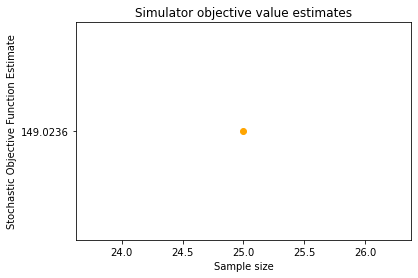

Simulator executed
Replica  1  with stoch OF  149.0236  det OF equiv  120.0 LB: SH simulator OF  42.53  Py simulator OF  47.4  std LB  0.1096

----------------------------- Replica 2
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 120.00
Stochastic Real Reward = 122.22 



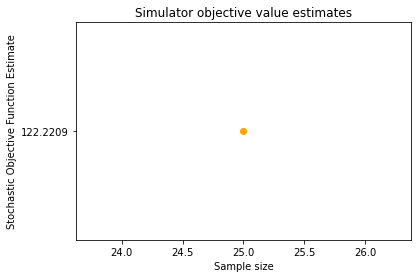

Simulator executed
Replica  2  with stoch OF  122.2209  det OF equiv  120.0 LB: SH simulator OF  68.72  Py simulator OF  68.7  std LB  0.0692

----------------------------- Replica 3
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 125.00
Stochastic Real Reward = 110.45 



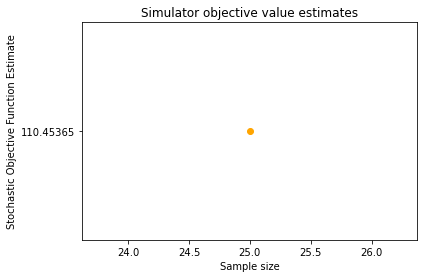

Simulator executed
Replica  3  with stoch OF  110.45365  det OF equiv  125.0 LB: SH simulator OF  53.83  Py simulator OF  60.8  std LB  0.156

----------------------------- Replica 4
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 160.00
Stochastic Real Reward = 134.40 



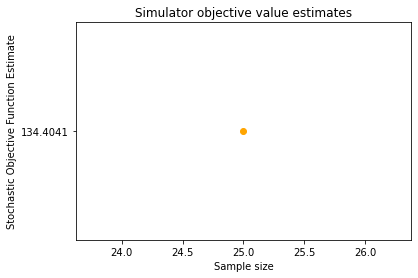

Simulator executed
Replica  4  with stoch OF  134.4041  det OF equiv  160.0 LB: SH simulator OF  15.12  Py simulator OF  20.7  std LB  0.0557

----------------------------- Replica 5
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 125.00
Stochastic Real Reward = 111.79 



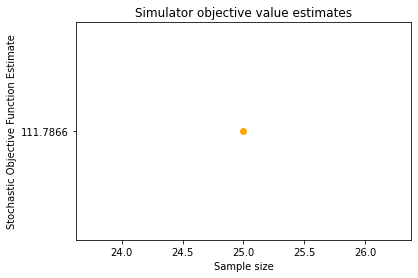

Simulator executed
Replica  5  with stoch OF  111.7866  det OF equiv  125.0 LB: SH simulator OF  27.32  Py simulator OF  34.8  std LB  0.0562

----------------------------- Replica 6
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 145.00
Stochastic Real Reward = 166.07 



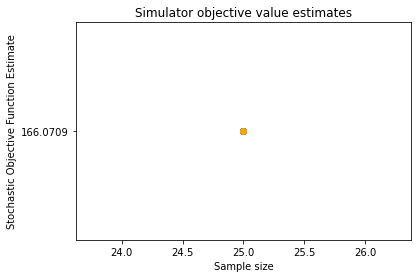

Simulator executed
Replica  6  with stoch OF  166.0709  det OF equiv  145.0 LB: SH simulator OF  1.51  Py simulator OF  10.9  std LB  0.0353

----------------------------- Replica 7
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 180.00
Stochastic Real Reward = 147.26 



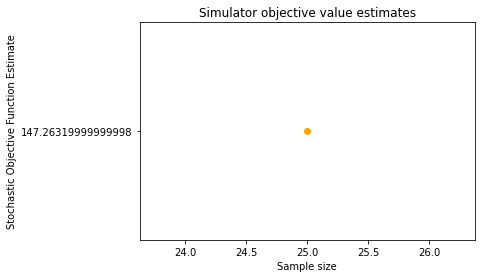

Simulator executed
Replica  7  with stoch OF  147.26319999999998  det OF equiv  180.0 LB: SH simulator OF  20.71  Py simulator OF  32.7  std LB  0.1149

----------------------------- Replica 8
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 140.00
Stochastic Real Reward = 144.62 



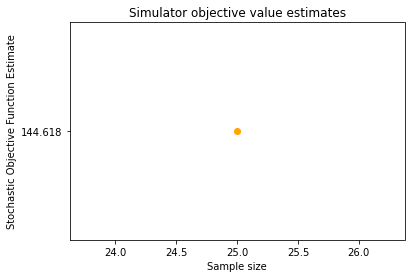

Simulator executed
Replica  8  with stoch OF  144.618  det OF equiv  140.0 LB: SH simulator OF  27.89  Py simulator OF  42.6  std LB  0.0973

----------------------------- Replica 9
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 145.00
Stochastic Real Reward = 155.96 



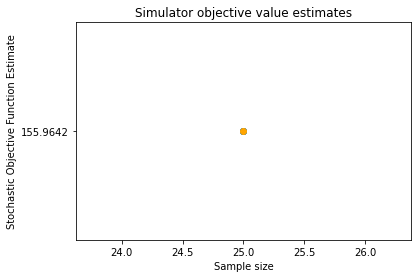

Simulator executed
Replica  9  with stoch OF  155.9642  det OF equiv  145.0 LB: SH simulator OF  2.67  Py simulator OF  18.8  std LB  0.1076

----------------------------- Replica 10
Instance:  p2.4.h
Reward obtained with PJS heuristic sol = 130.00
Stochastic Real Reward = 99.74 



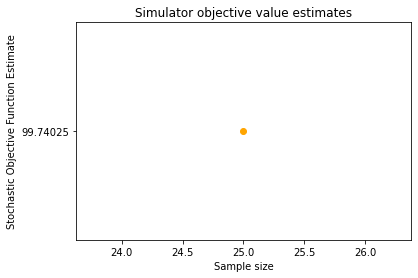

Simulator executed
Replica  10  with stoch OF  99.74025  det OF equiv  130.0 LB: SH simulator OF  6.87  Py simulator OF  24.0  std LB  0.0671


In [37]:
import time

StartTime = time.time()
num_sim = 10000

for r in num_replicas:  # For each replica
    try:
        os.remove("TravelingTime.xlsx")
    except:
        pass
    times = np.empty(shape=(len(instanceSP.N),len(instanceSP.N)))
    print("\n----------------------------- Replica "+str(r+1))
    # Populate the small SP tree to find (another) solution
    for i,j,s in instanceSP.N*instanceSP.N*instanceSP.S:
        instanceSP.time_stoch[i,j,s] = stoch_times(instanceSP,i,j,s)
        times[i][j] = instanceSP.time_stoch[i,j,s].value
        
    instanceSP.preprocess();  # Update to new values

    #Cplex
    #results_SP = opt.solve(instanceSP, tee=False, warmstart = True) #, symbolic_solver_labels=True )
    #print("   Solver time: ",round(results_SP.solver.time,2))
    #print_solver_info(instanceSP,  results_SP)
    #print_solver_info("SP",  results_SP)
    
    #Heuristic
    dfTimes = pd.DataFrame(times)
    dfTimes.to_excel("TravelingTime.xlsx",sheet_name='times',index=False)  
    execfile('top_pjs_heuristic.py')
        
    f = open("ResumeOutputs.txt", "r")
    
    resultInstance = f.readline().rstrip('\n').split("\t")
    # Compute metrics
    utility_det = resultInstance[2]
    Z_det[r] = utility_det   #deterministic solution in each replication
    utility_sto = resultInstance[3]
    Z_R[r] = utility_sto   #stochastic solution of each replication
    #print(Z_R, r)
  
    
    
    #print_solutionXvehicle(instanceSP)
    #print4simulator(instanceSP) -> Do it in the python program
    utility_sim = run_simulator(instanceName, instanceSP.nScn, utility_sto)
    
    print("Simulator executed")
    Z_Rsim[r] = utility_sim     #the result by Java simulator
    [avg_rew,std_rew,min_rew,max_rew,avg_rel] = simulate_sol(instanceName,num_sim)
    Z_Rsim2[r] = avg_rew  #the result by python simulator
    V_Rsim2[r] = round((std_rew**2)/num_sim,4)
    
    print("Replica ",r+1, " with stoch OF ", utility_sto," det OF equiv ", utility_det, 
          "LB: SH simulator OF ",utility_sim  ," Py simulator OF ", avg_rew ," std LB ", V_Rsim2[r])
    
    # Save the solution
    #for i,j,k in instanceSP.A*instanceSP.M:
     #   x_r[r,i,j,k] = instanceSP.x[i,j,k].value
      #  y_r[r,i,k] = instanceSP.y[i].value
        

In [38]:
print(Z_R, Z_det, r)

0              149.0236
1              122.2209
2             110.45365
3              134.4041
4              111.7866
5              166.0709
6    147.26319999999998
7               144.618
8              155.9642
9              99.74025
dtype: object 0    120.0
1    120.0
2    125.0
3    160.0
4    125.0
5    145.0
6    180.0
7    140.0
8    145.0
9    130.0
dtype: object 9


In [105]:
modelLarge = build_mod(S_large)
instanceLarge = modelLarge.create_instance(dataName)

    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    SetProduct.  Returning this set and not descending into the set operands.
    To descend into this operator, specify
    'subsets(expand_all_set_operators=True)' or to suppress this warning,
    specify 'subsets(expand_all_set_operators=False)'
    

In [108]:
print("\n---------------------- EVALUATE THE BEST SP SOLUTION IN A LARGE TREE  with ",S_large," scn\n")
        
# Choose the solution with best objective value
#best_replica = Z_R.idxmax()
best_replica = Z_Rsim2.idxmax() # Use the information on the simulator (python)
print("Best solution: ",best_replica+1," with SP objective function: ",Z_R[best_replica]," - ", Z_Rsim2[best_replica])

# Set the value of the 1st stage variables
for i,j,k in instanceLarge.A*instanceLarge.M:
    #print(x_r[best_replica,i,j,k],y_r[best_replica,i,k])
    instanceLarge.x[i,j,k].fix(x_r[best_replica,i,j,k])
    instanceLarge.y[i].fix(  y_r[best_replica,i,k])
    
instanceLarge.preprocess();  # Update to new values
#results_SPlarge = solve(instanceLarge, tee=True )    
results_SPlarge = opt.solve(instanceLarge, tee=True )
print("   Solver time: ",round(results_SPlarge.solver.time,2))
#instance.write("lp/problem_2ndStg_"+str(r)+".lp", io_options={'symbolic_solver_labels': True})
# Store the results
instanceLarge.solutions.load_from(results_SPlarge)
    
# Compute metrics
utility_det_large = round(sum(instanceLarge.utility[j]*instanceLarge.x[i,j,k].value for (i,j,k) in instanceLarge.A*instanceLarge.M),1)
utility_sto_large = round(instanceLarge.Total_Utility_Stoch(),2)
Z_R2stg = utility_sto_large
V_R2stg = compute_variance(instanceLarge)
V_R2stg = V_R2stg/instanceLarge.nScn # The variance of the estimator is divided by the sample size

print4simulator(instanceLarge) 
utility_sim = run_simulator(instanceName, instanceLarge.nScn, utility_sto_large)
[ avg_rew, std_rew, min_rew, max_rew, avg_rel] = simulate_sol(instanceName,num_sim, plot_time_dist = True)

print("Large tree " + str(best_replica+1) + " with stoch OF " + str(utility_sto_large) +\
      " det OF equiv " + str(utility_det_large) + " Std: " + str(round(math.sqrt(V_R2stg),1)) +"\n")
print("SH Simulator average value: ",utility_sim)
print("Py Simulator average value: ", avg_rew , " - std ", std_rew, " - avg reliability ", avg_rel)

TotalTime = round(time.time() - StartTime)
print("SAA solution in ", TotalTime, "sec.")


---------------------- EVALUATE THE BEST SP SOLUTION IN A LARGE TREE  with  100  scn

Best solution:  1  with SP objective function:  120.0  -  82.3

Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 22.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2022.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\EGHORB~1\AppData\Local\Temp\tmpvzm8qnzj.cplex.log' open.
CPLEX> New value for time limit in seconds: 20
CPLEX> Problem 'C:\Users\EGHORB~1\AppData\Local\Temp\tmpw3a24z57.pyomo.lp' read.
Read time = 0.01 sec. (0.16 ticks)
CPLEX> Problem name         : C:\Users\EGHORB~1\AppData\Local\Temp\tmpw3a24z57.pyomo.lp
Objective sense      : Maximize
Variables            :     801  [Nneg: 401,  Binary: 400]
Objective nonzeros   :     400
Linear const

ValueError: No value for uninitialized NumericValue object r[1,1]

What are the solutions found?

In [76]:
rep_sol = pd.DataFrame({'Z_det'  : Z_det,
                        'Z_R'    : Z_R,
                        'Z_Rsim' : Z_Rsim,
                        'Z_Rsim2': Z_Rsim2,
                        'V_Rsim2': V_Rsim2}, 
                       columns = ['Z_det', 'Z_R','Z_Rsim','Z_Rsim2','V_Rsim2'])
print(rep_sol)

   Z_det  Z_R  Z_Rsim  Z_Rsim2  V_Rsim2
0    120  120   120.0    120.0   0.0000
1    120  120   120.0    120.0   0.0000
2    120  120   120.0    120.0   0.0000
3    120  120   120.0    120.0   0.0000
4    125  120   124.1    121.0   0.0064
5    125  121   124.1    121.1   0.0064
6    140  137   139.1    135.9   0.0066
7    140  134   139.1    135.9   0.0066
8    120  120   120.0    120.0   0.0000
9    120  120   120.0    120.0   0.0000


Simulate the best solution chosen with the Python simulator

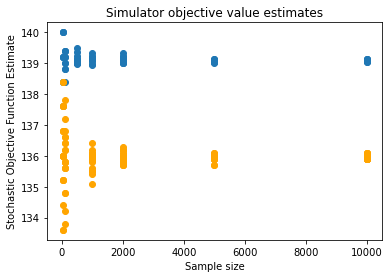

Simheuristic simulator:  139.1  Python simulator:  136.0


In [77]:
nsims = np.repeat([25, 100, 1000, 2000, 5000, 10000], 20)
avg_rew_sims = np.zeros(len(nsims))
std_rew_sims = np.zeros(len(nsims))
min_rew_sims = np.zeros(len(nsims))
max_rew_sims = np.zeros(len(nsims))
rel_rew_sims = np.zeros(len(nsims))
for r in range(len(nsims)):
    [avg_rew, std_rew, min_rew, max_rew, avg_rel] = simulate_sol(instanceName,nsims[r])
    avg_rew_sims[r] = avg_rew
    std_rew_sims[r] = std_rew
    min_rew_sims[r] = min_rew
    max_rew_sims[r] = max_rew
    rel_rew_sims[r] = avg_rel
#print(avg_rew_sims)
utility_sim = run_simulator(instanceName,nsims,avg_rew_sims)
reward_sim = round(np.mean(avg_rew_sims),1)

with open('./sim_sol/simoutput.txt', 'w') as ff:
    ff.write('# num_simulation	stosolution \n')
    for s in range(len(nsims)):
        ff.write(str(s))
        ff.write('\t') 
        ff.write(str(avg_rew_sims[s]))
        ff.write('\n') 
        
print('Simheuristic simulator: ', utility_sim , ' Python simulator: ', reward_sim)

In [78]:
pd.DataFrame({'n_sims': nsims,
             'avg_reward': avg_rew_sims,
             'std_reward': std_rew_sims,
             'min_reward': min_rew_sims,
             'max_reward': max_rew_sims,
             'avg_reliability': rel_rew_sims}, 
             columns = ['n_sims','avg_reward','std_reward', 'min_reward', 'max_reward','avg_reliability'])

,n_sims,avg_reward,std_reward,min_reward,max_reward,avg_reliability
0,25,136.0,8.0,120.0,140.0,95.0
1,25,137.6,6.5,120.0,140.0,97.0
2,25,136.0,8.0,120.0,140.0,95.0
3,25,136.0,8.0,120.0,140.0,95.0
4,25,137.6,6.5,120.0,140.0,97.0
...,...,...,...,...,...,...
115,10000,136.0,8.0,100.0,140.0,95.0
116,10000,136.1,7.9,100.0,140.0,95.1
117,10000,135.9,8.1,100.0,140.0,94.9
118,10000,135.9,8.1,100.0,140.0,94.9


### Compute the SAA intervals. 

Because we are maximazing, the lower bound of the optimal stochastic objective function is the expected value of a particular solution. 

To compute the **lower bound**, we choose the solution with the best SP objective value. Then, this solution is evaluated in a large number of scenarios. The expected value is the average value and the variance of this estimate the variance of the value provided at each scenario.

* In this implementation, we compute for each replica the expected value with the simheuristics simulator.
* Because the first stage variables are fixed, the large problem is equivalent to assess a particular set of routes in $S_{2stg}$ independent scenarios.
* This evaluation (it is not really a new optimization problem) is performed very fast, but it takes a lot of time to build the model. Therefore an external simulator can be used to perform this calculations.
* The objective function is already the $Z_{S_{2stg}}$ value if the optimization problem is used, or the average value of the ${S_{2stg}}$ simulations.
* The variance of the estimator of the lower bound is computed as the variance of the values of each scenario divided by the sample size (the larger is the number of simulations, the more confident we are about the average value observed).

$$
\hat{Z}_{S_{2stg}}(\hat{x}) = \frac{1}{\vert S_{2st} \vert} \sum_{s=1}^{S_{2stg}} (\sum_{k=1}^m r^{ks})
$$

The **upper bound** is the average of the objective function values found in each replica:
$$
\overline{Z}_{S} = \frac{1}{R}\sum_{r=1}^R Z_S^r
$$
and the variance of the lower bound:
$$
\sigma^2_{Z_{S}} = \frac{1}{R(R-1)} \sum_{r=1}^R (\overline{Z}_S - Z_S^r)^2
$$

In [79]:
# Bound computed with the instanceLarge 
lower_bound     = Z_R2stg
lower_bound_var = round(V_R2stg,2)

# Bound computed with the simulator
lower_bound     = Z_Rsim2[best_replica]
lower_bound_var = V_Rsim2[best_replica]

In [80]:
upper_bound     = round(np.mean(Z_R),2)
upper_bound_var = round(np.var(Z_R, ddof=1)/len(Z_R),2)

In [81]:
gap     = round(upper_bound - lower_bound,2)
gap_var = upper_bound_var + lower_bound_var
gap_sd  = round(sqrt(gap_var),2)

In [82]:
print("Best estimate - replica", best_replica+1,"\t LB\t", lower_bound, " UB \t", upper_bound, "\t --> gap = ", gap)
print("\t\t\t\tVar(LB) ",lower_bound_var, " \tVar(UB) ", upper_bound_var, "\t --> sd(gap) = ", gap_sd )

Best estimate - replica 7 	 LB	 135.9  UB 	 123.2 	 --> gap =  -12.7
				Var(LB)  0.0066  	Var(UB)  4.26 	 --> sd(gap) =  2.07


In [83]:
print(instanceName,"; ",S,"; ",S_large,"; ",cVar,"; ",R,"; ",TotalTime,"; ",
      Z_det[best_replica],"; ",Z_R[best_replica],"; ",Z_Rsim[best_replica],"; ",Z_Rsim2[best_replica],"; ",
      lower_bound,"; ",upper_bound,"; ",gap,";    ",lower_bound_var,"; ",upper_bound_var,"; ",gap_sd)

p2.4.k ;  25 ;  100 ;  0.05 ;  10 ;  344 ;  140 ;  137 ;  139.1 ;  135.9 ;  135.9 ;  123.2 ;  -12.7 ;     0.0066 ;  4.26 ;  2.07


In [84]:
with open('./simulador_top/rutas/'+instanceName+'.txt') as f:
    print(f.read())

0;8;20
0;6;5;4;20
0;11;9;10;20
0;12;13;20


In [85]:
#instance.y.display()
for i in instanceLarge.N:
    if (instanceLarge.y[i].value >= 0.1):
        print(str(k)," - ", str(i), " y=", str(instanceLarge.y[i].value))

4  -  4  y= 3
4  -  5  y= 2
4  -  6  y= 1
4  -  7  y= 20
4  -  8  y= 1
4  -  9  y= 2
4  -  10  y= 3
4  -  11  y= 1
4  -  12  y= 1
4  -  13  y= 19
4  -  18  y= 20
4  -  19  y= 20
4  -  20  y= 20


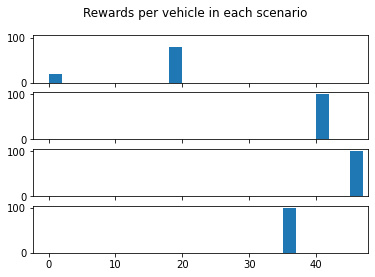

In [86]:
# Check time distribution
reward = plot_reward_instance(instanceLarge)

Vehicle 1 Routes fulfilled 80.0% - 20 failures out of 100
Vehicle 2 Routes fulfilled 100.0% - 0 failures out of 100
Vehicle 3 Routes fulfilled 100.0% - 0 failures out of 100
Vehicle 4 Routes fulfilled 100.0% - 0 failures out of 100


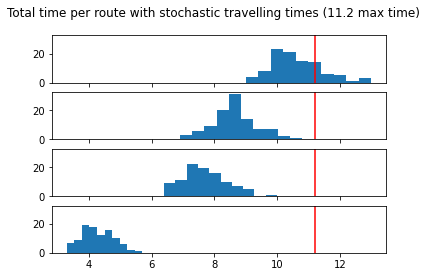

In [87]:
# Check time distribution
route_time = plot_total_time(instanceLarge)

In [ ]:

#for i in nsims:
#    print("number of run:", i, "sto profit:", avg_rew_sims)


In [ ]:
#def build_simoutput_file(instanceName,avg_rew_sims):
#    with open('./sim_sol/simoutput.txt','w') as hh:
#         hh.write('# inst	simsolution \n')
#         nsims = np.repeat([25, 100, 500, 1000, 2000, 5000, 10000, 25000, 50000], 10)
#         blank= ''
#         for h in nsims:
#             blank += instanceName + '\t' + str(s) + '\t' + str(avg_rew_sims) + '\n'
#         hh.write(blank)
#    return()
#df_sim_out = pd.read_csv('./simulador_top/sim_sol/simoutput.txt.txt', delimiter = "\t", index_col=False, skiprows=[0], header = None)
#df_sim_out.columns = ["instance", "solution"]

In [ ]:
#  for i in str(num_sim):
#        print("run:", i, "reward:", df_reward)

In [ ]:
def getStochasticValue(mean=None,variance=None,scale=None,location=None):
    if scale==None and location==None:
         #phi = math.sqrt(variance + mean * mean)
         #scale = math.log((mean * mean) / phi)
         #location = math.sqrt(math.log((phi * phi) / (mean * mean)))
         variance = variance * mean
         sigma = math.sqrt(math.log(1 + variance / (mean * mean)))
         mu = math.log(mean) - sigma * sigma / 2
         stochProfit = np.random.lognormal(mean=mu,sigma=sigma)
         print(stochProfit)
    elif mean==None and variance==None:
        stochProfit = np.random.lognormal(mean=scale, sigma=location)
    else:
        print("Error using lognormal distribution!!")
    return stochProfit

StartTime = time.time()
num_sim = 10000

for r in num_replicas:  # For each replica
    print("\n----------------------------- Replica "+str(r+1))
    # Populate the small SP tree to find (another) solution
    for i,j,s in instanceSP.N*instanceSP.N*instanceSP.S:
        instanceSP.time_stoch[i,j,s] = getStochasticValue(mean=e.cost, variance=test.variance)